<h1> Восстановление золота

**Описание проекта:**

Компания [«Цифра»](http://zyfra.com/) разрабатывает решения для эффективной работы промышленных предприятий. В нашем распоряжении данные с параметрами добычи и очистки золота из золотосодержащей руды.


**Цель проекта:**

Подготовить прототип модели машинного обучения. Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды, тем самым помочь оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

**Этапы проекта:**

1. [Загрузка и обзор данных](#Загрузка-данных)
2. [Предобработка данных](#Предобработка-данных)
3. [Анализ данных](#Анализ-данных)
4. [Построение модели](#Модель)
5. [Выводы](#Выводы)

<a id='Загрузка-данных'></a>

<h2> Обзор данных

Импортируем необходимые библиотеки для будущей работы. Считаем данные из csv-файлов в переменные `df`,`train` и `test` и изучим их.

Пути к файлам:

- `/datasets/gold_industry_full.csv`
- `/datasets/gold_industry_train.csv`
- `/datasets/gold_industry_test.csv`

In [1]:
# импорты из стандартной библиотеки
import warnings
import optuna

# импорты сторонних библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# импорты модулей текущего проекта
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model  import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler

#настройка
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
optuna.logging.set_verbosity(optuna.logging.WARNING)

#константа
RANDOM_STATE = 12345

In [2]:
try:
    full = pd.read_csv(r'C:\jupyter projects\2module_project\gold_industry_full.csv')
    train = pd.read_csv(r'C:\jupyter projects\2module_project\gold_industry_train.csv')
    test = pd.read_csv(r'C:\jupyter projects\2module_project\gold_industry_test.csv')
    sns.set_style("darkgrid")
except:
    full = pd.read_csv('/datasets/gold_industry_full.csv')
    train = pd.read_csv('/datasets/gold_industry_train.csv')
    test = pd.read_csv('/datasets/gold_industry_test.csv')
    sns.set_style("darkgrid")

In [3]:
data = [full, train, test]
names = ['Исходные данные', 'Тренировочная выборка', 'Тестовая выборка']

def info(df, name):
    print(f'\n\033[1m{name}\033[0m')
    display(df.head())
    print(f'\nТипы данных:\n{df.dtypes.value_counts()}\n')
    print(f'Количество строк: {df.shape[0]}\n\n\
Количество столбцов: {df.shape[1]}\n\n\
Количество дбликатов: {df.duplicated().sum()}\n\n\
Всего пропусков: {df.isna().sum().sum()}\n')
    fig = (100*df.isna().sum()/df.shape[0]).sort_values()
    fig.plot(kind='bar', figsize=(14,9), color='indianred')
    plt.xlabel('Признаки')
    plt.ylabel('Количество пропусков')
    plt.title(name)
    plt.show()
    display(df.describe())
    print('_'*110)


Исходные данные


,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686



Типы данных:
float64    86
object      1
dtype: int64

Количество строк: 19439

Количество столбцов: 87

Количество дбликатов: 0

Всего пропусков: 4481



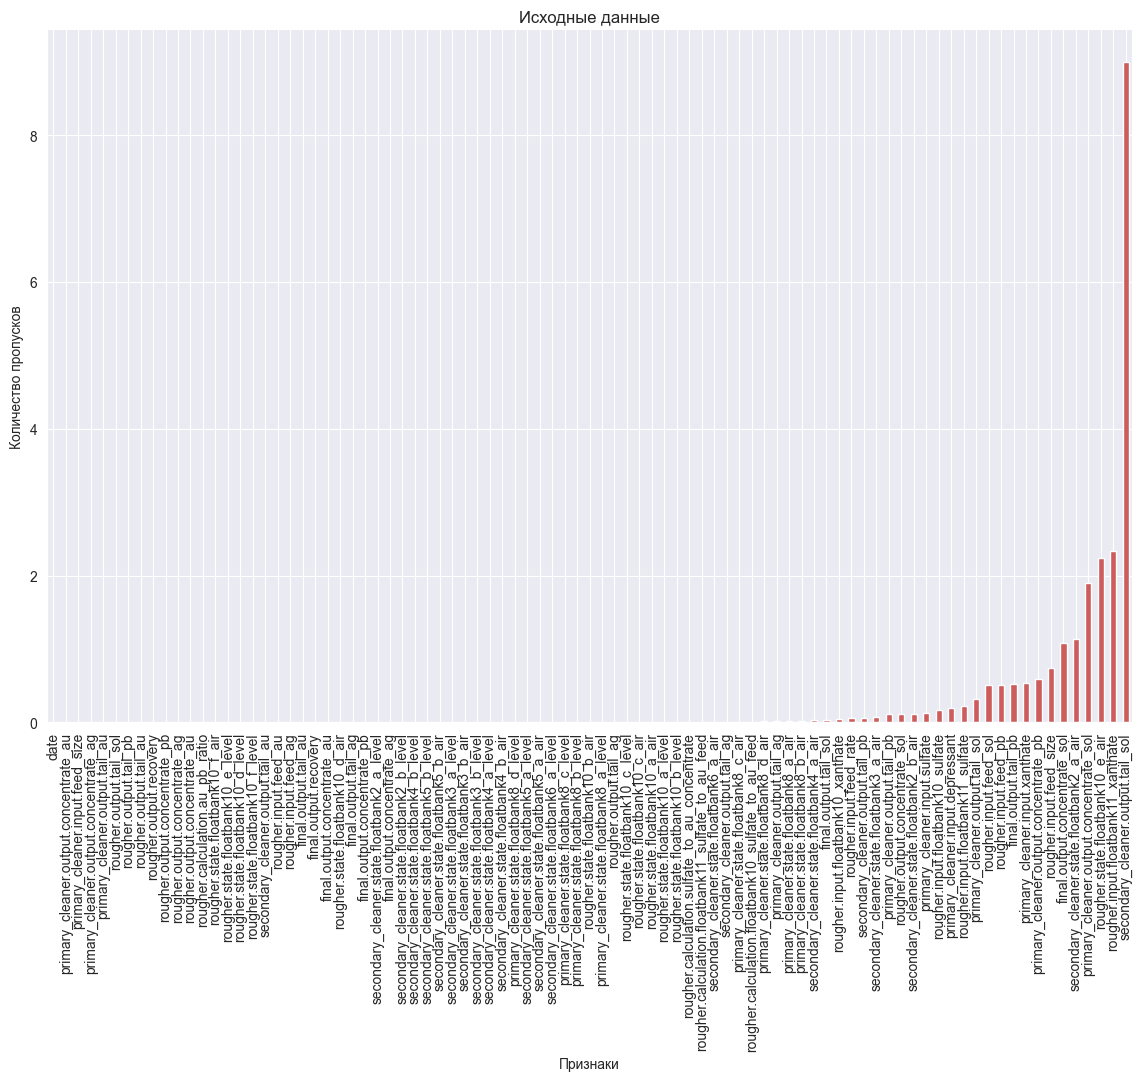

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,19439.000000,19439.000000,19339.000000,19340.000000,19428.000000,19294.000000,19405.000000,19431.000000,19438.000000,19438.000000,...,17691.000000,19439.000000,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000
mean,8.266097,8.794927,3.598085,36.695114,478.320042,58.970310,12.334373,6.021474,1105.315068,-376.610690,...,7.167247,44.076513,5.168470,9.978895,9.501224,67.050208,3.042467,9.688589,2.705795,10.583728
std,1.955092,1.936847,1.049486,5.145445,105.373758,21.634478,3.427317,1.127263,160.826798,93.909667,...,3.916079,5.129784,1.372348,1.669240,2.787537,10.125840,0.922808,2.328642,0.949077,2.868782
min,0.010000,0.010000,0.010000,0.010000,0.002986,0.046369,0.001083,0.000568,-0.042069,-657.949759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.854384,7.237967,2.887280,34.207799,416.525453,47.435103,10.000362,5.398678,999.661867,-499.835165,...,3.845475,43.402215,4.251240,9.137262,7.722820,63.299712,2.461138,8.062878,2.040119,8.938947
50%,8.125839,8.593574,3.534895,37.202650,499.416120,54.610197,12.001174,6.008273,1001.072890,-300.263994,...,7.685827,45.011244,5.066094,10.102433,9.218961,68.172738,2.984909,9.743623,2.748730,10.622456
75%,9.769917,10.213771,4.244161,40.039133,550.172183,65.023044,14.716595,6.798051,1205.620588,-299.981998,...,10.411296,46.275313,5.895527,11.035769,10.947813,72.686642,3.571351,11.134294,3.333216,12.104271
max,13.731330,14.596026,7.142594,53.477742,717.508837,484.967466,36.118275,9.703448,1521.980372,-273.776101,...,26.000772,52.756638,16.001945,17.031899,19.615720,100.000000,8.245022,19.552149,5.804178,22.317730


______________________________________________________________________________________________________________

Тренировочная выборка


,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686



Типы данных:
float64    86
object      1
dtype: int64

Количество строк: 14579

Количество столбцов: 87

Количество дбликатов: 0

Всего пропусков: 3050



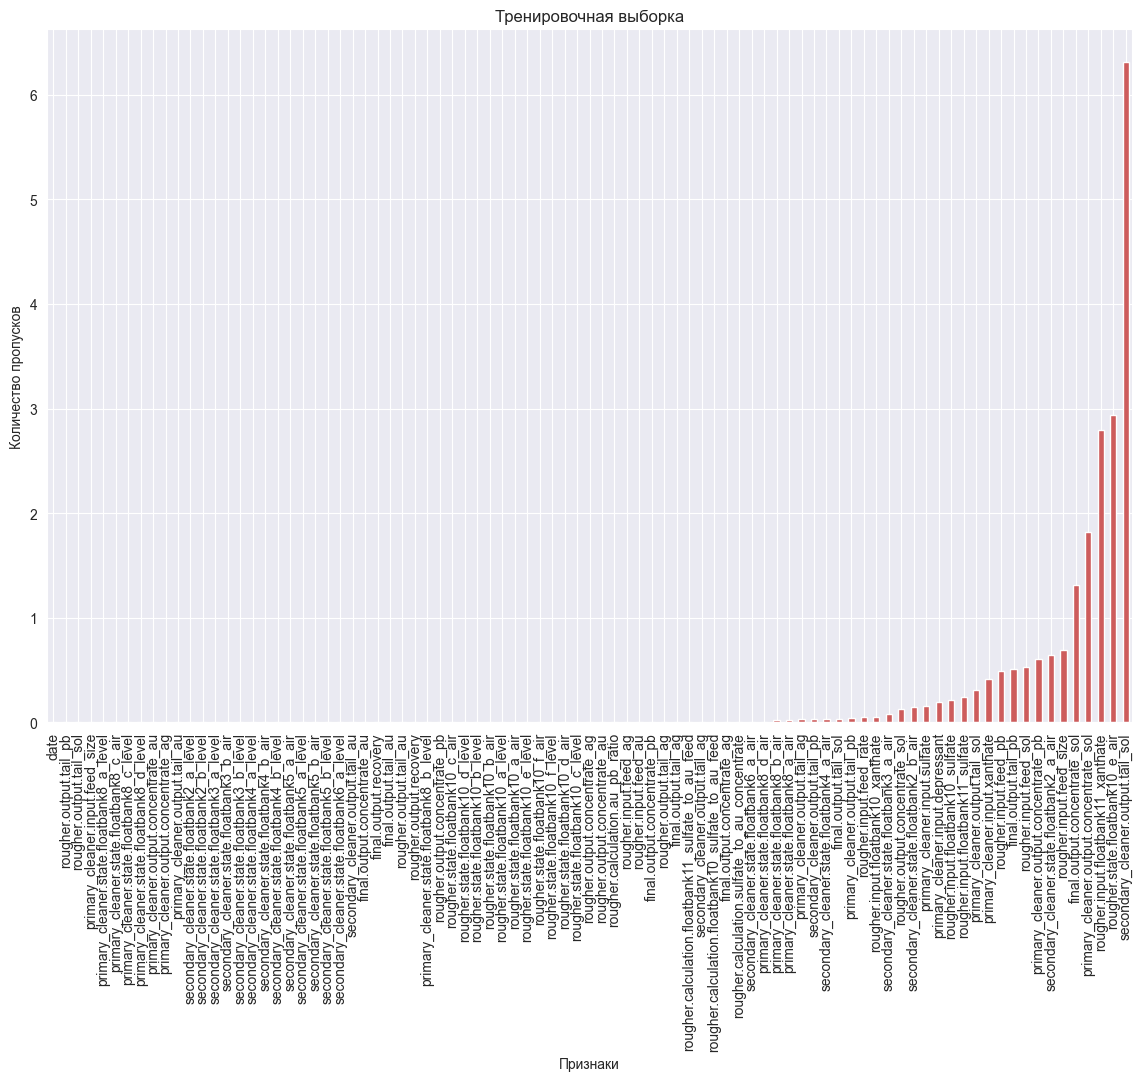

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,14579.000000,14579.000000,14507.000000,14502.000000,14572.000000,14478.000000,14548.000000,14572.000000,14579.000000,14579.000000,...,13659.000000,14579.000000,14578.000000,14578.000000,14387.000000,14579.000000,14579.000000,14578.000000,14504.000000,14574.000000
mean,8.352941,8.877460,3.604221,36.561420,474.332784,58.922712,12.427399,5.994854,1104.208278,-379.367166,...,7.111347,43.979499,5.192145,9.923809,9.566676,66.759066,3.087939,9.731972,2.719985,10.612745
std,1.934376,1.922536,1.056063,5.209823,108.503552,22.407410,3.428939,1.152873,162.235606,94.652311,...,3.909951,5.471437,1.388014,1.706976,2.805654,10.619709,0.915187,2.358143,0.958929,2.871075
min,0.010000,0.010000,0.010000,0.010000,0.002986,0.049194,0.001083,0.000568,-0.042069,-657.949759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.932996,7.341922,2.880490,34.093951,411.048483,47.278490,10.002832,5.304167,999.644856,-499.861797,...,3.784897,43.345906,4.283347,9.103183,7.860030,63.114596,2.505287,8.088928,2.036512,9.013412
50%,8.225284,8.715859,3.532399,37.097511,498.187968,54.361187,12.003320,6.003053,1000.982624,-300.314199,...,7.629968,44.975014,5.118647,10.046455,9.301970,67.962788,3.029238,9.818512,2.774847,10.670515
75%,9.832210,10.255843,4.257282,39.899799,549.586552,64.464926,14.929903,6.796632,1292.663971,-299.989315,...,10.367050,46.275153,5.925380,10.981203,11.001573,72.598187,3.614098,11.169187,3.353845,12.130827
max,13.731330,14.596026,7.052325,53.475325,717.508837,484.967466,36.118275,9.703448,1512.299531,-273.776101,...,26.000772,52.756638,16.001945,16.705297,19.423912,100.000000,8.245022,19.552149,5.804178,22.317730


______________________________________________________________________________________________________________

Тестовая выборка


,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575
1,2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
2,2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,...,22.993827,-501.559663,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155
3,2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,...,23.032807,-501.287889,19.977466,-500.159903,17.980463,-500.504602,12.949071,-500.009937,20.010332,-508.337973
4,2017-12-09 18:59:59,5.735249,6.165220,4.512346,37.810642,558.713584,86.434874,7.823471,7.490356,1198.005449,...,23.001911,-499.947838,20.023735,-499.713680,17.990955,-500.334769,13.007523,-499.968459,19.995999,-499.788805



Типы данных:
float64    52
object      1
dtype: int64

Количество строк: 4860

Количество столбцов: 53

Количество дбликатов: 0

Всего пропусков: 375



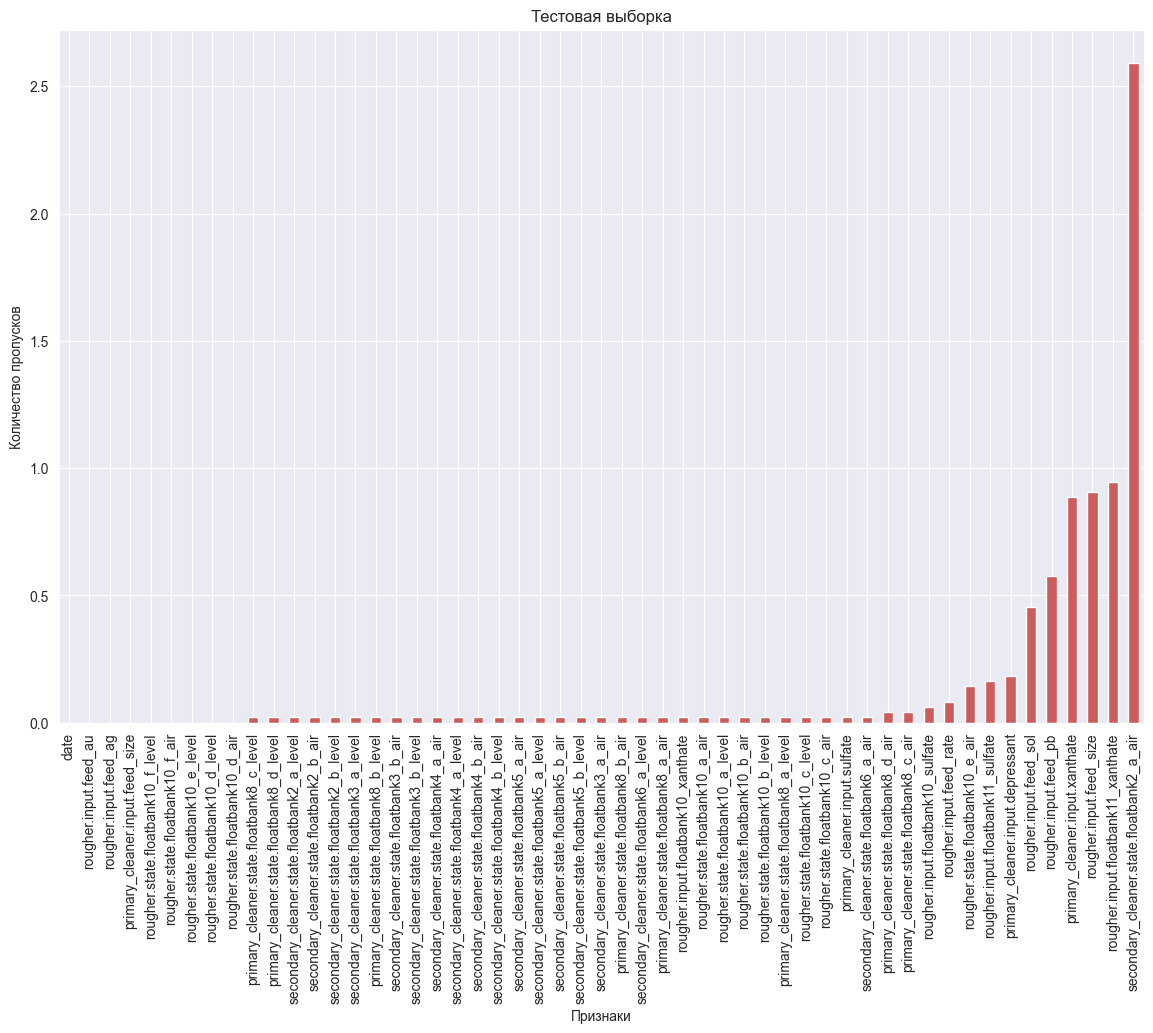

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,4860.000000,4860.000000,4832.000000,4838.000000,4856.000000,4816.000000,4857.000000,4859.000000,4859.000000,4859.000000,...,4.859000e+03,4859.000000,4.859000e+03,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000
mean,8.005584,8.547348,3.579662,37.095864,490.285103,59.113400,12.055735,6.101308,1108.635895,-368.340127,...,1.985770e+01,-488.665140,1.557025e+01,-464.176507,16.594103,-490.815250,12.945971,-489.583564,19.053888,-504.678924
std,1.993590,1.958601,1.029377,4.926284,94.371623,19.125122,3.407642,1.042754,156.493143,91.155929,...,5.913105e+00,44.392714,4.927361e+00,65.706994,5.724305,32.258443,5.533176,37.084609,5.548996,38.690186
min,0.010000,0.010000,0.010000,0.010000,0.012786,0.046369,0.018907,0.015783,300.792494,-600.568138,...,1.079872e-16,-799.704969,2.489718e-17,-799.860767,-0.371498,-797.142475,1.358469,-800.006180,0.160386,-809.734800
25%,6.574363,6.975898,2.903612,34.510841,434.099695,47.596984,9.890429,5.499808,999.715729,-499.731972,...,1.501123e+01,-500.704004,1.202172e+01,-500.196517,11.073822,-500.483564,9.011890,-500.129913,14.963953,-500.668501
50%,7.812923,8.179714,3.540772,37.499761,502.118742,55.509481,11.997859,6.099805,1001.414798,-300.181367,...,1.996807e+01,-499.892919,1.501240e+01,-499.540776,16.631195,-499.873136,11.999417,-499.955304,19.960006,-500.033769
75%,9.556589,10.084339,4.199847,40.461315,555.596563,66.661547,14.496072,6.802101,1202.837565,-299.961547,...,2.498900e+01,-498.652030,1.999949e+01,-400.302329,19.983191,-498.852815,15.004198,-499.643776,24.974583,-499.460134
max,13.417156,14.533698,7.142594,53.477742,702.523396,363.989699,30.010759,9.396928,1521.980372,-281.039299,...,3.008450e+01,-383.373053,2.398898e+01,-114.250832,33.215996,-288.963521,24.177106,-141.934397,32.028529,-104.427459


______________________________________________________________________________________________________________


In [4]:
for i in range(3):
    info(data[i], names[i])

<h3>Вывод:

Мы вывели общие сведения о датасетах. Отметим важные моменты:

- Перед нами задача регрессии
- Целевые признаки проекта - `rougher.output.recovery` и `final.output.recovery`
- В датасетах `full` и `train` совпадает количество столбцов. В `test` отсутствует большая часть признаков
- Во всех датасетах встречаются только 2 типа данных - `float` и `object`. Стоит рассмотреть тип данных у признака `date`
- В `full` и `train` больше всего пропусков в одном и том же столбце - `secondary_cleaner.output.tail_sol`
- В описательной статистике заметны минимальные значения в нулях. Скорее всего это пропуски

<a id='Предобработка-данных'></a>

<h2> Предобработка данных

<h3> MAE

Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака `rougher.output.recovery` через следующую формулу:

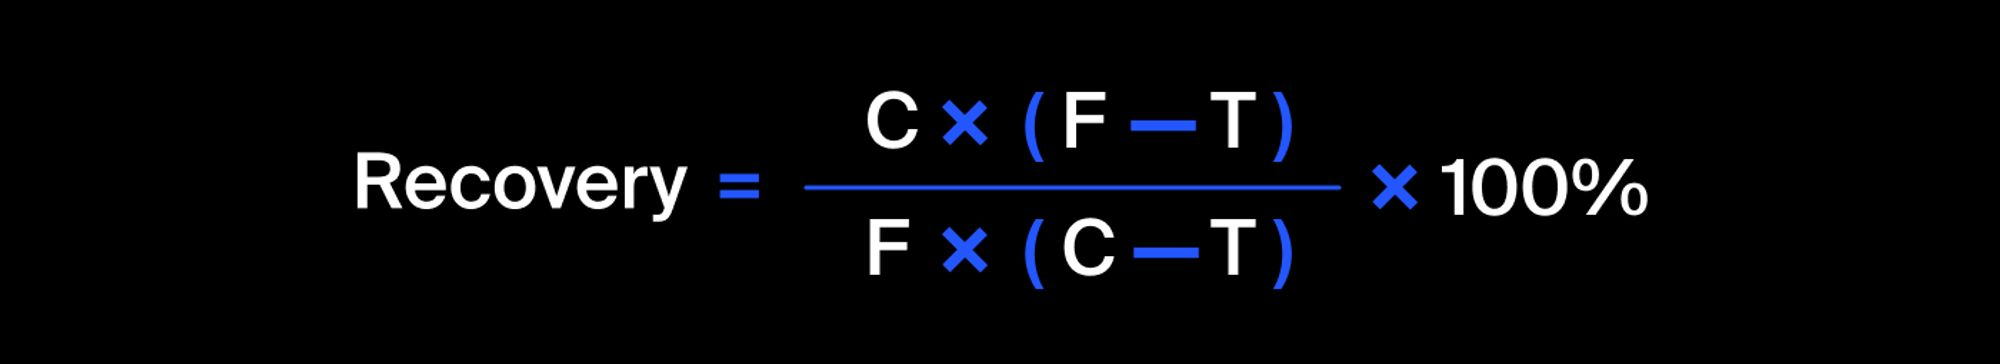

In [5]:
# считаем эффективность обогащения на трейне
C,F,T = train['rougher.output.concentrate_au'],train['rougher.input.feed_au'],train['rougher.output.tail_au']
recovery = (C*(F-T))/(F*(C-T))*100

# проверяем
recovery

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14574    87.684717
14575    90.677361
14576    89.574376
14577    87.724007
14578    88.890579
Length: 14579, dtype: float64

Найдем MAE(среднюю абсолютную ошибку) между нашими расчётами и истинным значением признака.

In [6]:
print('MAE:', mean_absolute_error(train['rougher.output.recovery'], recovery))

MAE: 9.83758577644259e-15


Значение MAE показательно низкое и стремится к нулю, что говорит о корректных рассчетах эффективности обогащения в целевом признаке `rougher.output.recovery`. 

<h3> Отсутствующие столбцы

Мы уже знаем, что количество столбцов в `full` и `train` совпадает. Сравним их по названиям. Если они буду совпадать, то проанализируем признаки, недоступные в тестовой выборке, сравнив их с признаками из тренировочной.

In [8]:
set_full = set(full.columns.to_list())
set_train = set(train.columns.to_list())
set_test = set(test.columns.to_list())

display(sorted(list(set_train^set_full)))

[]

Признаки исходных данных и тренировочной выборки совпадают. Рассмотрим тестовую выборку.

In [9]:
print(f'Количество признаков в тестовой выборке: {test.shape[1]}')
print('Количество признаков, отсутствующих в тестовой выборке:', len(list(set_train^set_test)), '\n')
print('Типы признаков:\n', train[list(set_train^set_test)].dtypes.value_counts())
display(sorted(list(set_train^set_test)))

Количество признаков в тестовой выборке: 53
Количество признаков, отсутствующих в тестовой выборке: 34 

Типы признаков:
 float64    34
dtype: int64


['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В датасете тестовой выборки нет довольно много признаков - аж 32, все они типа `float`. Однако в условии задачи указано, что в тестовой выборке отсутствуют некоторые признаки, потому что замеряются и/или рассчитываются значительно позже. 

Добавим в датасет `test` только целевые признаки - `rougher.output.recovery` и `final.output.recovery`, так как добавлять остальные смысла нет.

In [10]:
# добавим целевые признаки в тест
full_recovery = full[['date','rougher.output.recovery','final.output.recovery']].copy()
test_from_full = full_recovery.query('date in @test.date')
test = test.merge(test_from_full,on='date')

print(f'Исходные данные:{full.shape}\nТренировочная выборка:{train.shape}\nТестовая выборка:{test.shape}')

Исходные данные:(19439, 87)
Тренировочная выборка:(14579, 87)
Тестовая выборка:(4860, 55)


<h3> Предобработка

Проведем основую часть предобработки данных.

Обозревая данные мы отметили, что в датасетах присутствуют только два типа данных - `float` и `object`. Следовательно, столбец `date` не приведен к стандартному типу данных `datetime`. 

Исправим это и сменим тип данных признака `date` с `object` на `datetime`.

In [11]:
# меняем тип данных
data = [full, train, test]
for df in data:
    print('Тип данных "date" до обработки:', df['date'].dtypes)
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d %H:%M:%S', errors='coerce')
    print('Тип данных "date" после обработки:', df['date'].dtypes, '\n')

Тип данных "date" до обработки: object
Тип данных "date" после обработки: datetime64[ns] 

Тип данных "date" до обработки: object
Тип данных "date" после обработки: datetime64[ns] 

Тип данных "date" до обработки: object
Тип данных "date" после обработки: datetime64[ns] 



Взглянем на количество пропусков в тренировочном и тестовом датасетах.

In [12]:
print('Пропуски в тренировочной выборке:', train.isna().sum().sum(), \
      '\nПропуски в тестовой выборке:', test.isna().sum().sum())

Пропуски в тренировочной выборке: 3050 
Пропуски в тестовой выборке: 375


In [13]:
# полнострочные пропуски
print('Тренировочная выборка:', train.shape)
print('Тренировочная выборка без полнострочных пропусков:', \
      train.dropna(axis=0, how='all').shape, '\n')

print('Тестовая выборка:', test.shape)
print('Тестовая выборка без полнострочных пропусков:', \
      test.dropna(axis=0, how='all').shape)

Тренировочная выборка: (14579, 87)
Тренировочная выборка без полнострочных пропусков: (14579, 87) 

Тестовая выборка: (4860, 55)
Тестовая выборка без полнострочных пропусков: (4860, 55)


Пропущенные значения чаще встречаются в тренировочной выборке. Полнострочных пропусков в тренировочном и тестовом датасетах нет. 

Ранее можно было заметить, что в датасетах присутствуют нулевые значения. Скорее всего это пропуски. Заменим их на `NaN` значения и посмотрим на зависимость количества объектов от количества признаков.

In [14]:
train = train.replace({'0':np.nan, 0:np.nan})
test = test.replace({'0':np.nan, 0:np.nan})
print('Тренировочная выборка:', train.isna().sum().sum(), '\nТестовая выборка:', test.isna().sum().sum())

Тренировочная выборка: 9555 
Тестовая выборка: 377


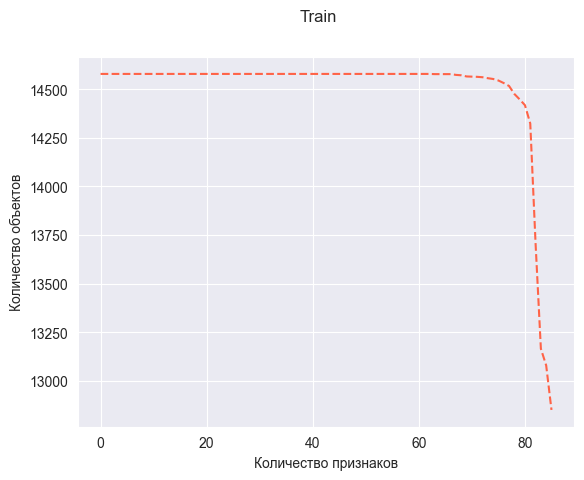

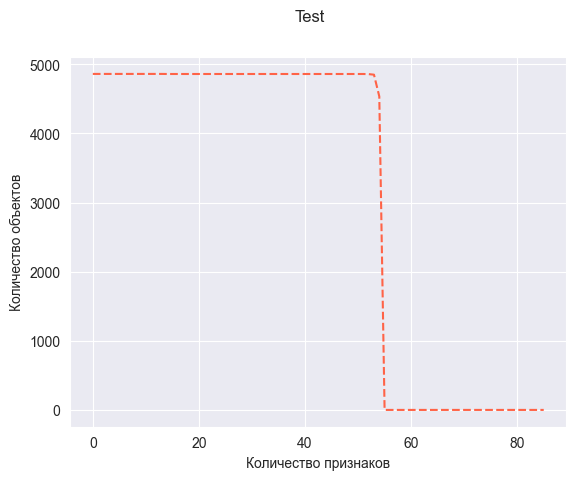

In [15]:
def miss_value(df, title):
    miss_value = []
    for i in range(1,87):
        miss_value.append(df.dropna(axis=0, thresh=i).shape[0])
    plt.plot(miss_value, color='tomato', ls='--')
    plt.xlabel('Количество признаков')
    plt.ylabel('Количество объектов')
    plt.suptitle(title)
    plt.show()
    
miss_value(train, 'Train')
miss_value(test, 'Test')

Мы видим, что для тренировочной выборки количество объектов резко сокращается, когда количество признаков приближается к 75. То же самое заметно и на тестовой выборке, только с порогом в 52-53 объектов. Выберем эти значения как максимально допустимый порог объектов в столбцах.

Посмотрим на процент пропусков по столбцам в трейне и тесте.

In [16]:
def missing_values(df):
    display((df.isna().sum().sort_values(ascending=False)/len(df)*100)[:25])

In [17]:
missing_values(train)
missing_values(test)

secondary_cleaner.output.tail_sol         11.297071
secondary_cleaner.output.tail_pb           5.014061
secondary_cleaner.output.tail_ag           4.993484
secondary_cleaner.output.tail_au           4.986625
rougher.state.floatbank10_e_air            2.942589
rougher.output.concentrate_sol             2.825983
rougher.input.floatbank11_xanthate         2.791687
rougher.output.concentrate_au              2.702517
rougher.output.concentrate_pb              2.702517
rougher.output.recovery                    2.702517
rougher.output.concentrate_ag              2.702517
primary_cleaner.output.concentrate_sol     2.558475
final.output.concentrate_sol               1.989162
primary_cleaner.output.concentrate_pb      1.344399
final.output.tail_pb                       1.008300
primary_cleaner.output.tail_sol            0.987722
primary_cleaner.output.concentrate_ag      0.740792
primary_cleaner.output.concentrate_au      0.740792
primary_cleaner.output.tail_pb             0.720214
primary_clea

secondary_cleaner.state.floatbank2_a_air      2.592593
rougher.input.floatbank11_xanthate            0.946502
rougher.input.feed_size                       0.905350
primary_cleaner.input.xanthate                0.884774
rougher.input.feed_pb                         0.576132
rougher.input.feed_sol                        0.452675
primary_cleaner.input.depressant              0.205761
rougher.input.floatbank11_sulfate             0.164609
rougher.state.floatbank10_e_air               0.144033
rougher.input.feed_rate                       0.082305
rougher.input.floatbank10_sulfate             0.061728
primary_cleaner.state.floatbank8_c_air        0.041152
primary_cleaner.state.floatbank8_d_air        0.041152
secondary_cleaner.state.floatbank2_b_air      0.041152
secondary_cleaner.state.floatbank2_a_level    0.020576
secondary_cleaner.state.floatbank4_b_level    0.020576
primary_cleaner.state.floatbank8_d_level      0.020576
secondary_cleaner.state.floatbank2_b_level    0.020576
secondary_

В тренировочном датасете пропуски чаще встречаются в отвальных хвостах, тогда как в тестовом - в флотационной установке.

Удалим строки в тренировочной выборке, где заполнено более 60 признаков, и в тестовой, где заполнено более 45. Проверим пропуски в целевых признаках.

In [18]:
train.dropna(axis=0, thresh=70, inplace=True)
test.dropna(axis=0, thresh=50, inplace=True)

missing_values(train)
missing_values(test)

display(train['rougher.output.recovery'].isna().sum())

secondary_cleaner.output.tail_sol         11.217905
secondary_cleaner.output.tail_pb           4.936153
secondary_cleaner.output.tail_ag           4.915557
secondary_cleaner.output.tail_au           4.908691
rougher.state.floatbank10_e_air            2.945215
rougher.output.concentrate_sol             2.814774
rougher.input.floatbank11_xanthate         2.725525
rougher.output.concentrate_pb              2.691199
rougher.output.concentrate_au              2.691199
rougher.output.recovery                    2.691199
rougher.output.concentrate_ag              2.691199
primary_cleaner.output.concentrate_sol     2.471509
final.output.concentrate_sol               1.970342
primary_cleaner.output.concentrate_pb      1.256350
primary_cleaner.output.tail_sol            0.974873
final.output.tail_pb                       0.940546
primary_cleaner.output.tail_pb             0.707126
primary_cleaner.output.tail_ag             0.693396
rougher.input.feed_size                    0.693396
primary_clea

secondary_cleaner.state.floatbank2_a_air      2.572546
rougher.input.floatbank11_xanthate            0.926116
rougher.input.feed_size                       0.884956
primary_cleaner.input.xanthate                0.864375
rougher.input.feed_pb                         0.576250
rougher.input.feed_sol                        0.452768
primary_cleaner.input.depressant              0.185223
rougher.input.floatbank11_sulfate             0.144063
rougher.state.floatbank10_e_air               0.144063
rougher.input.feed_rate                       0.061741
rougher.input.floatbank10_sulfate             0.041161
primary_cleaner.state.floatbank8_d_air        0.020580
secondary_cleaner.state.floatbank2_b_air      0.020580
primary_cleaner.state.floatbank8_c_air        0.020580
secondary_cleaner.state.floatbank3_a_air      0.000000
secondary_cleaner.state.floatbank2_b_level    0.000000
secondary_cleaner.state.floatbank3_a_level    0.000000
secondary_cleaner.state.floatbank3_b_air      0.000000
secondary_

392

Как видно, для тренировочной выборки ничего особо не изменилось, однако в тестовой мы избавились от пропусков в некоторых столбцах флотационной установки.

Заполним все пропуски значениями из предыдущих наблюдений.

In [19]:
# КОД РЕВЬЮЕРА
train.shape[0]

14566

In [20]:
train.fillna(method='ffill', inplace=True)
test.fillna(method='ffill', inplace=True)

#train = train.dropna(subset = ['rougher.output.recovery','final.output.recovery'])
#test = test.dropna(subset = ['rougher.output.recovery','final.output.recovery'])

#train.dropna(inplace=True)
#test.dropna(inplace=True)         

missing_values(train)
missing_values(test)

display(train['rougher.output.recovery'].isna().sum())

date                                          0.0
primary_cleaner.output.tail_sol               0.0
secondary_cleaner.state.floatbank3_b_level    0.0
secondary_cleaner.state.floatbank3_b_air      0.0
secondary_cleaner.state.floatbank3_a_level    0.0
secondary_cleaner.state.floatbank3_a_air      0.0
secondary_cleaner.state.floatbank2_b_level    0.0
secondary_cleaner.state.floatbank2_b_air      0.0
secondary_cleaner.state.floatbank2_a_level    0.0
secondary_cleaner.state.floatbank2_a_air      0.0
primary_cleaner.output.tail_pb                0.0
secondary_cleaner.state.floatbank4_a_level    0.0
primary_cleaner.output.tail_ag                0.0
primary_cleaner.output.tail_au                0.0
primary_cleaner.output.concentrate_sol        0.0
primary_cleaner.output.concentrate_pb         0.0
primary_cleaner.output.concentrate_ag         0.0
primary_cleaner.output.concentrate_au         0.0
primary_cleaner.state.floatbank8_d_level      0.0
primary_cleaner.state.floatbank8_d_air        0.0


date                                          0.0
secondary_cleaner.state.floatbank3_b_air      0.0
primary_cleaner.state.floatbank8_b_level      0.0
primary_cleaner.state.floatbank8_c_air        0.0
primary_cleaner.state.floatbank8_c_level      0.0
primary_cleaner.state.floatbank8_d_air        0.0
primary_cleaner.state.floatbank8_d_level      0.0
secondary_cleaner.state.floatbank2_a_air      0.0
secondary_cleaner.state.floatbank2_a_level    0.0
secondary_cleaner.state.floatbank2_b_air      0.0
secondary_cleaner.state.floatbank2_b_level    0.0
secondary_cleaner.state.floatbank3_a_air      0.0
secondary_cleaner.state.floatbank3_a_level    0.0
secondary_cleaner.state.floatbank3_b_level    0.0
primary_cleaner.state.floatbank8_a_level      0.0
secondary_cleaner.state.floatbank4_a_air      0.0
secondary_cleaner.state.floatbank4_a_level    0.0
secondary_cleaner.state.floatbank4_b_air      0.0
secondary_cleaner.state.floatbank4_b_level    0.0
secondary_cleaner.state.floatbank5_a_air      0.0


0

In [21]:
# КОД РЕВЬЮЕРА
train.shape[0] / 14566

1.0

In [22]:
train.shape, test.shape

((14566, 87), (4859, 55))

 <h3> Вывод

По итогам предобработки данных, мы:

- Убедились в корректности рассчетов эффективности обогащения и в том, что значения целевого признака `rougher.output.recovery` валидны для последующей работы
- Проверили какие признаки отсутствуют в тестовой выборке и добавили в нее целевые параметры
- Провели предобработку данных: 
    - Сменили тип данных признака `date`
    - Избавились от пропусков

<a id='Анализ-данных'></a>

<h2> Анализ данных

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах:

- В сырье
- В черновом концентрате
- В концентрате после первой очистки 
- В финальном концентрате

In [23]:
# словари
concentrate = {  
    'au':['rougher.input.feed_au',
          'rougher.output.concentrate_au',
          'primary_cleaner.output.concentrate_au',
          'final.output.concentrate_au'],
    
    'ag':['rougher.input.feed_ag',
          'rougher.output.concentrate_ag',
          'primary_cleaner.output.concentrate_ag',
          'final.output.concentrate_ag'],
    
    'pb':['rougher.input.feed_pb',
          'rougher.output.concentrate_pb',
          'primary_cleaner.output.concentrate_pb',
          'final.output.concentrate_pb']
              }  

conc_colors = {
    'rougher.input.feed_ag':'orange',
    'rougher.output.concentrate_ag':'#8673a1',
    'primary_cleaner.output.concentrate_ag':'#65bccd',
    'final.output.concentrate_ag':'#90bf73', 
    'rougher.input.feed_au':'orange',
    'rougher.output.concentrate_au':'#8673a1', 
    'primary_cleaner.output.concentrate_au':'#65bccd',
    'final.output.concentrate_au':'#90bf73',
    'rougher.input.feed_pb':'orange',
    'rougher.output.concentrate_pb':'#8673a1',
    'primary_cleaner.output.concentrate_pb':'#65bccd',
    'final.output.concentrate_pb':'#90bf73'
         }

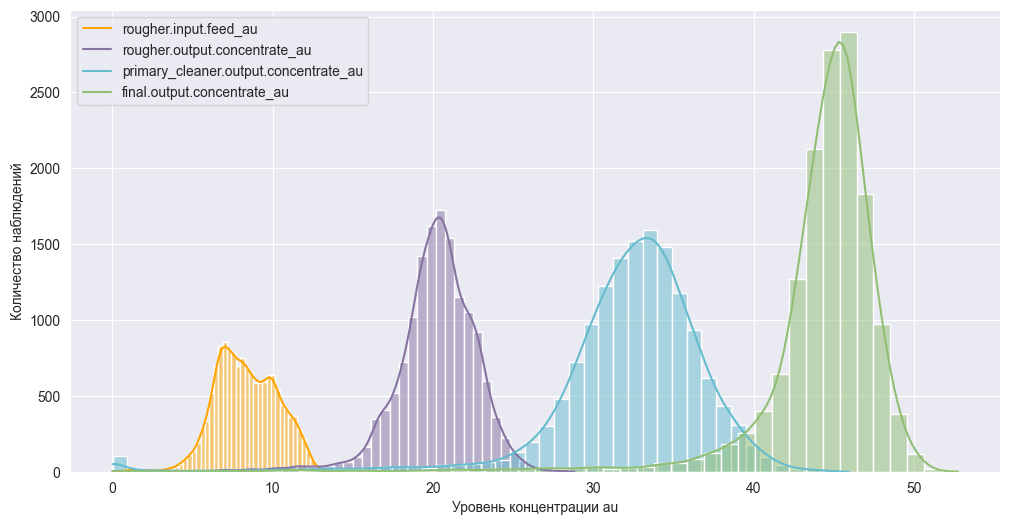

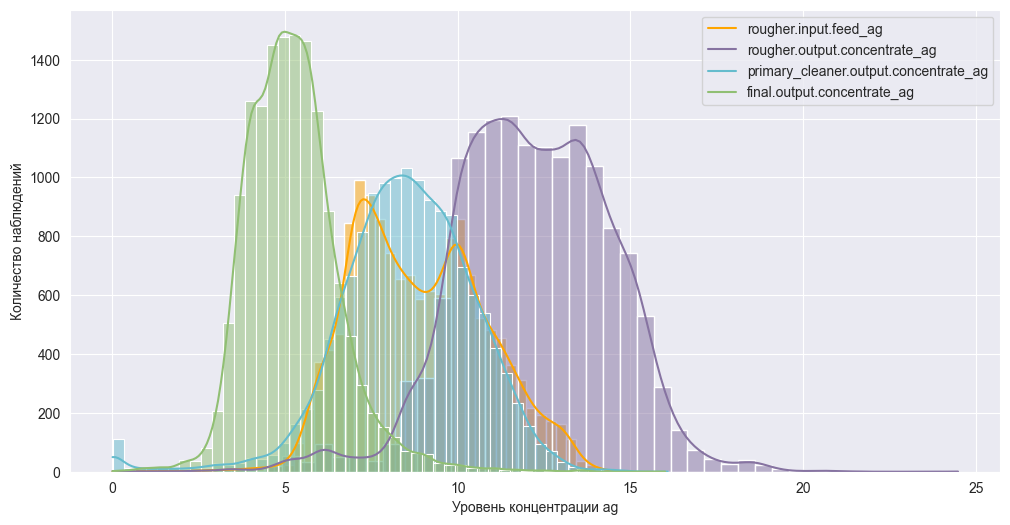

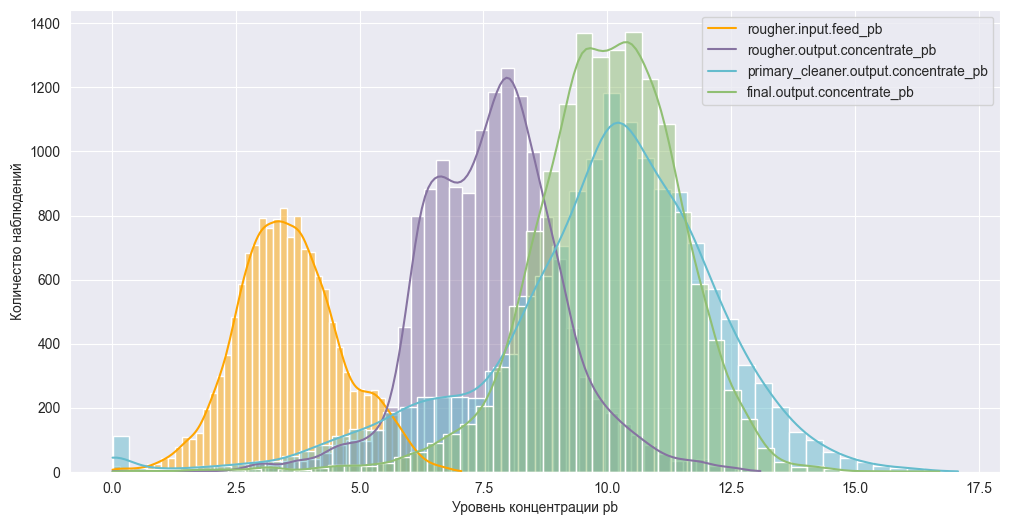

In [24]:
# графики
def concentrate_plot(column):
    f, ax = plt.subplots(figsize=(12,6))
    ax.set(xlabel=f'Уровень концентрации {column}', ylabel='Количество наблюдений')
    for stage in concentrate[column]:
        sns.histplot(data=train, x=stage, bins=50, color=conc_colors[stage], kde=True, label=column)
    plt.legend(concentrate[column])
    plt.show() 
    
for key in concentrate:
        concentrate_plot(key)

Видно, что концентрация золота регулярно растет на каждом этапе, что хорошо для бизнеса. Концентрация серебра наоборот идет на спад. А вот показатели свинца в концентрате после первой очистки и в финальном концентрате довольно близки.

Также на графиках заметны выбросы для каждого металла. Возможно они появились вследствие сбоя оборудования на производстве. Не будем удалять их, так как в такой ситуации стоит обратиться к коллегам или экспертам компании и уточнить был ли это сбой, или такие показатели вполне нормальны для производства.

Сравним распределения размеров гранул исходного сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

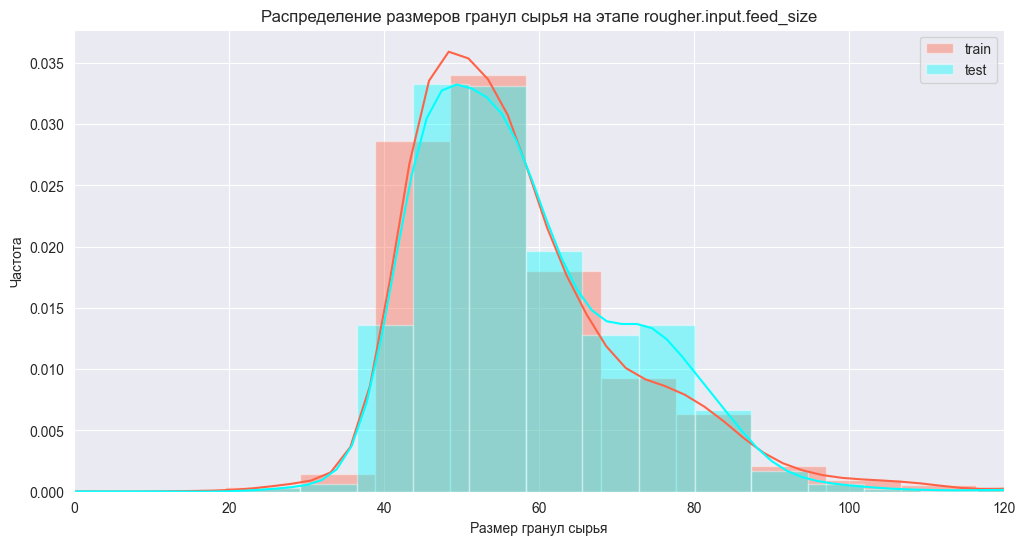

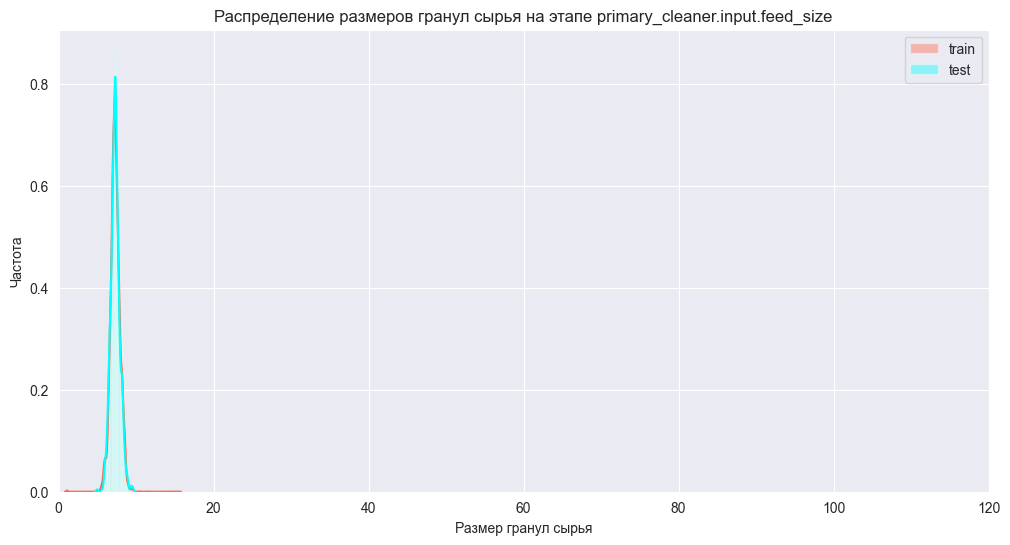

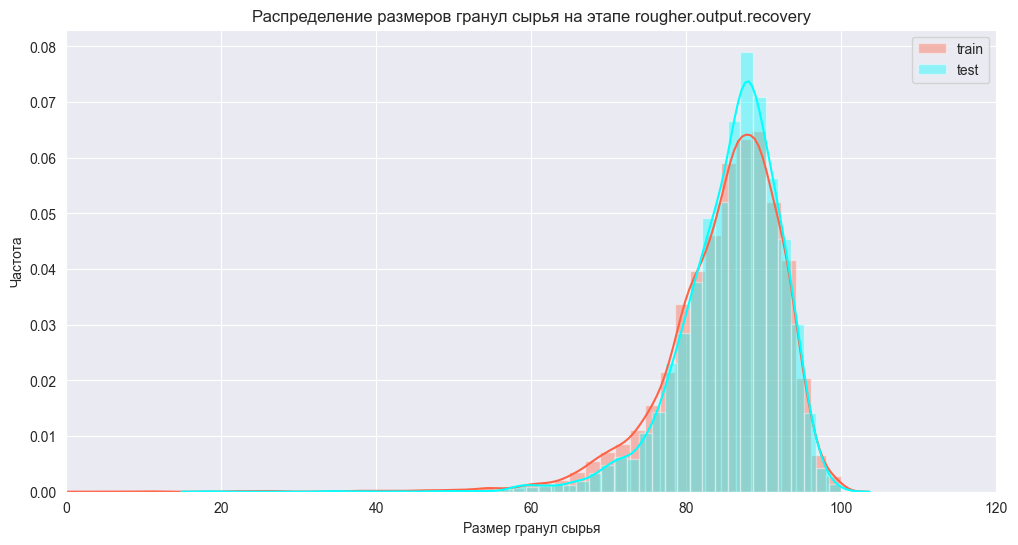

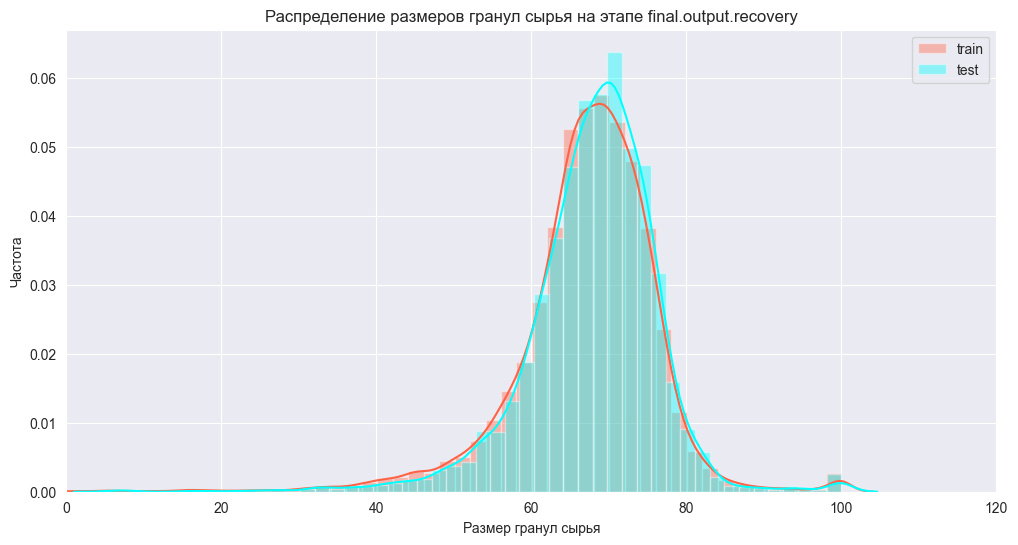

In [25]:
# признаки с размерами гранул
feed = ['rougher.input.feed_size', 
        'primary_cleaner.input.feed_size', 
        'rougher.output.recovery', 
        'final.output.recovery']

# график
def feed_plot(column):
    f, ax = plt.subplots(figsize=(12,6))
    sns.distplot(train[column], bins=50, label='train', color='tomato')
    sns.distplot(test[column], bins=50, label='test', color='cyan')
    plt.legend()
    ax.set(xlim=(0, 120), xlabel='Размер гранул сырья', ylabel='Частота',
           title=f'Распределение размеров гранул сырья на этапе {column}' )
    plt.show()
    
for i in range(len(feed)):
    feed_plot(feed[i])

Распределения размеров гранул исходного сырья на обучающей и тестовой выборках почти не отличаются, можно работать с данными дальше. 

Исследуем суммарную концентрацию металлов на разных стадиях: 

- В сырье
- В черновом концентрате
- В концентрате после первой очистки
- В финальном концентрате

In [26]:
# добавляем в словарь значения для sol
concentrate['sol'] = ['rougher.input.feed_sol',
                      'rougher.output.concentrate_sol',
                      'primary_cleaner.output.concentrate_sol',
                      'final.output.concentrate_sol']

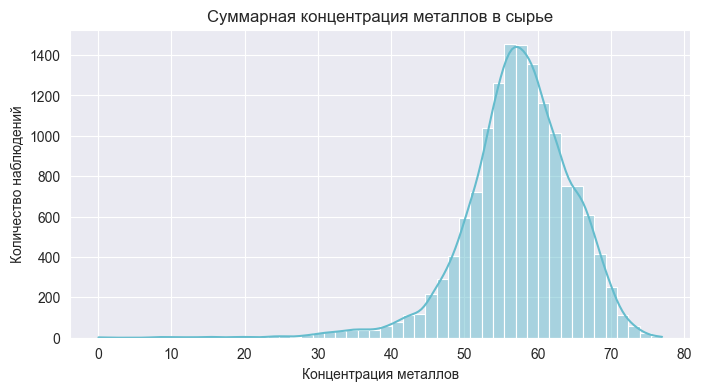

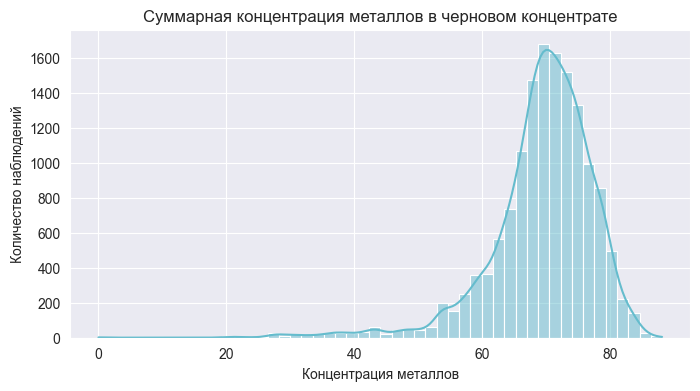

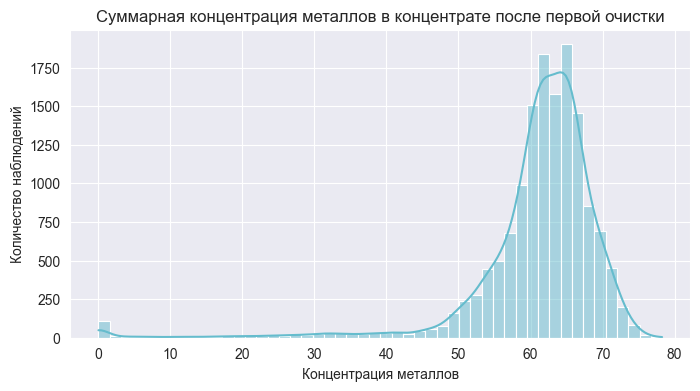

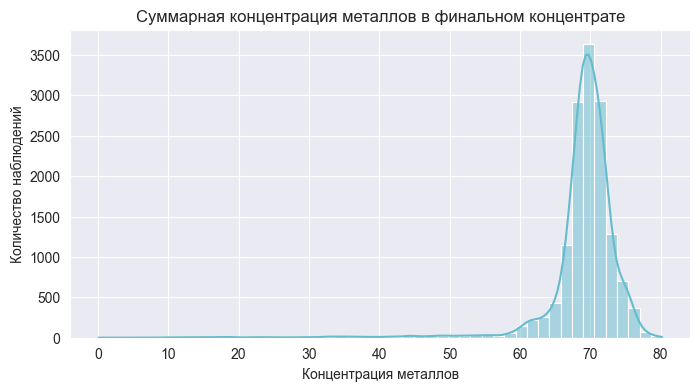

In [27]:
names = {
    0:'сырье',
    1:'черновом концентрате', 
    2:'концентрате после первой очистки',
    3:'финальном концентрате'
}

def sum_concentration_col(i):
    # сумма концентраций всех металлов по каждой из стадий
    sum_conc= train[concentrate['au'][i]] + train[concentrate['pb'][i]] \
    + train[concentrate['ag'][i]] + train[concentrate['sol'][i]]
    # график
    f, ax = plt.subplots(figsize=(8, 4))
    sns.histplot(sum_conc, bins=50, 
                 color='#65bccd', 
                 kde=True)
    ax.set(xlabel=f'Концентрация металлов', 
           ylabel='Количество наблюдений', 
           title=f'Суммарная концентрация металлов в {names[i]}' )
    plt.show()

for i in range(4):
    sum_concentration_col(i)

<h3> Вывод

Проанализировав данные, можно выделить несколько моментов:

- Распределение концентрации металлов нормальное
- Больше всего выбросов в нулевых значениях в концентратах после первой очистки
- Распределения размеров гранул исходного сырья на обучающей и тестовой выборках почти не отличаются
- Нулевые выбросы в основном присутствуют в значениях концентрата после первой очистки. Так как эти признаки отсутствуют в тестовой выборке, не будем их обрабатывать.

<a id='Модель'></a>

<h2> Модель

Перейдем к построению модели машинного обучения.

Оставим в тренировочной выборке только те признаки, что есть в тестовой.

In [28]:
# до удаления
print(f'Train до удаления: {train.shape}\n')

# удаляем столбцы
train_set = train.columns.to_list()
test_set = test.columns.to_list()
train_and_test = list(set(train_set)&set(test_set))
train = train[train_and_test]

# просле удаления
print(f'Train после удаления: {train.shape}\nTest: {test.shape}')

Train до удаления: (14566, 87)

Train после удаления: (14566, 55)
Test: (4859, 55)


Напишем функцию для вычисления sMAPE.

In [29]:
def sMAPE(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

Напишем такие функции, которые, на вход принимая тренировочный датасет, будут выделять целевую переменную и признаки, масштабировать их и проводить перекрестную проверку на значении sMAPE для выбранной модели.

In [30]:
train.drop(['date'], axis=1, inplace=True)
test.drop(['date'], axis=1, inplace=True)

In [31]:
def train_final(df, model):
    features = df.drop(['final.output.recovery'], axis=1)
    target = df['final.output.recovery']

    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    scorer = make_scorer(sMAPE, greater_is_better=False)
    return (abs(np.mean(cross_val_score(model, features, target, 
                                        cv=5, scoring=scorer))))

In [32]:
def train_rougher(df, model):
    features = df.drop(['final.output.recovery',
                        'rougher.output.recovery'], axis=1)
    target = df['rougher.output.recovery']
    
    #масштабируем
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    scorer = make_scorer(sMAPE, greater_is_better=False)
    return (abs(np.mean(cross_val_score(model, features, target, 
                                        cv=5, scoring=scorer))))

Напишем функцию для нахождения итогового значения sMAPE.

In [33]:
def result_sMAPE(model, type_model):
    sMAPE_rougher = train_rougher(train, model)
    sMAPE_final= train_final(train,model)
    print(f'Rougher sMAPE для модели {type_model}: {sMAPE_rougher}')
    print(f'Final sMAPE для модели {type_model}: {sMAPE_final:.2f}')
    print(f'Итоговое sMAPE  для модели {type_model}: \
{(sMAPE_rougher*0.25+sMAPE_final*0.75):.2f}')   

Применим функцию к модели `DummyRegressor` и будем считать значение на выходе как константу.

In [34]:
dummy_clf = DummyRegressor()
rs=result_sMAPE(dummy_clf,'DummyRegressor')
rs

Rougher sMAPE для модели DummyRegressor: 7.458869660931657
Final sMAPE для модели DummyRegressor: 10.21
Итоговое sMAPE  для модели DummyRegressor: 9.52


Константное значение sMAPE = 9.52. Постараемся найти модель, которая будет давать меньший результат. 

Построим три модели:

- `LinearRegression`
- `GradientBoostingRegressor`
- `LGBMRegressor`

и подберем для них лучшие гиперпараметры.

In [35]:
def objective(trial, features, target, model_name):
    if model_name == "GradientBoostingRegressor":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 2, 15),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'n_estimators':trial.suggest_int('n_estimators', 1, 100, 10),
            'max_depth': trial.suggest_int('max_depth', 1, 15)
        }
        model = GradientBoostingRegressor(**params, random_state=RANDOM_STATE)
    elif model_name == "LGBMRegressor":
        params = {
            'num_leaves': trial.suggest_int('num_leaves', 2, 30),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'n_estimators':trial.suggest_int('n_estimators', 1, 100, 10),
            'max_depth': trial.suggest_int('max_depth', -1, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 20)
        }
        model = LGBMRegressor(**params, random_state=RANDOM_STATE,
                              force_col_wise=True, verbose=-1)
    else:
        model = LinearRegression()
        
    scorer = make_scorer(sMAPE, greater_is_better=False)
    return (abs(np.mean(cross_val_score(model, features, target, 
                                        cv=5, n_jobs=-1,scoring=scorer))))

In [36]:
def optimize_models(train):
    models_to_optimize = ['LinearRegression', 'GradientBoostingRegressor', 'LGBMRegressor']
    best_params = {}
    for model_name in models_to_optimize:
        model_params = {}
        for target_name in ['rougher.output.recovery', 'final.output.recovery']:
            if target_name == 'rougher.output.recovery':
                features = train.drop(['rougher.output.recovery'], axis=1)
            else:                
                features = train.drop(['final.output.recovery'], axis=1)
            target = train[target_name]
            
            scaler = StandardScaler()
            features = scaler.fit_transform(features)

            study = optuna.create_study(direction='minimize')
            study.optimize(lambda trial: objective(trial, features, target, model_name),
                           n_trials=5)

            model_params[target_name] = {
                'params': study.best_params,
                'sMAPE': study.best_value
            }

        best_params[model_name] = model_params

    return best_params

best_params = optimize_models(train)

In [37]:
rows = []
for model_name, targets in best_params.items():
    for target_name, details in targets.items():
        params = details['params']
        sMAPE = details['sMAPE']
        row = {'Model': model_name, 'Target': target_name, 'sMAPE': sMAPE, **params}
        rows.append(row)

df = pd.DataFrame(rows)
df.pivot_table(columns=['Model', 'Target'])

Model             GradientBoostingRegressor                          \
Target                final.output.recovery rougher.output.recovery   
learning_rate                      0.072876                0.099884   
max_depth                          7.000000               10.000000   
min_child_samples                       NaN                     NaN   
min_samples_split                  5.000000                3.000000   
n_estimators                      10.000000               13.000000   
num_leaves                              NaN                     NaN   
sMAPE                              8.381565                5.748479   

Model                     LGBMRegressor                          \
Target            final.output.recovery rougher.output.recovery   
learning_rate                  0.050748                0.031943   
max_depth                      6.000000                0.000000   
min_child_samples              7.000000               12.000000   
min_samples_split                   NaN                     NaN   
n_estimators                  71.000000               81.000000   
num_leaves                    24.000000               26.000000   
sMAPE                          7.815643                5.250090   

Model                  LinearRegression                          
Target            final.output.recovery rougher.output.recovery  
learning_rate                       NaN                     NaN  
max_depth                           NaN                     NaN  
min_child_samples                   NaN                     NaN  
min_samples_split                   NaN                     NaN  
n_estimators                        NaN                     NaN  
num_leaves                          NaN                     NaN  
sMAPE                          8.060527                 6.33947

Для обоих целевых признаков лучше всего себя показывает `LGBMRegressor` - sMAPE на кросс-валидации для `final.output.recovery` равен 7.500005, а для `rougher.output.recovery` - 4.747905.
Применим полученные гиперпараметры и посмотрим на итоговый sMAPE.

In [38]:
def weighted_sMAPE(sMAPE_rougher, sMAPE_final):
    return 0.25 * sMAPE_rougher + 0.75 * sMAPE_final

In [39]:
def sMAPE(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

In [40]:
model_LGBM_rougher = LGBMRegressor(random_state=RANDOM_STATE, 
                                   num_leaves=13, 
                                   min_child_samples=16, 
                                   max_depth=13, 
                                   n_estimators=100,
                                   learning_rate=0.090876, 
                                   verbose=-1)
sMAPE_rougher = train_rougher(train, model_LGBM_rougher)

In [41]:
model_LGBM_final = LGBMRegressor(random_state=RANDOM_STATE, 
                                 num_leaves=6,
                                 max_depth=15, 
                                 n_estimators=100,
                                 min_child_samples=100,
                                 learning_rate=0.1, 
                                 verbose=-1)
sMAPE_final = train_final(train, model_LGBM_final)

In [42]:
final_sMAPE = weighted_sMAPE(sMAPE_rougher, sMAPE_final)
print(f'Final weighted sMAPE: {final_sMAPE}')

Final weighted sMAPE: 7.302300867679618


<div class="alert alert-danger">
<font size="4"><b>❌ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
        <b></b>

Формально вполне возможна ситуация, что на первом таргете лучше справляется одна модель (например, лес), на втором - другая (например, линейная модель), поэтому нам надо отдельно найти лучшую модель на первом таргете и отдельно - на втором, и уже затем их результаты взвесить, вычислив smape итоговый. И такая ситуация сейчас и у тебя. Посмотри внимательно: у тебя на `rougher` лучшая метрика отнюдь не у деревьев, а у линейной. А ты берёшь в тестирование бустинг.

Тем более реальна ситуация, что на одном таргете будут лучшими одни гиперпараметры, на другом - другие. Очевидно, если обучим две разные модели и посчитаем их итоговый взвешенный smape, то он будет лучше, чем если подбирать гиперпараметры под взвешенный smape сразу, как это делаешь ты сейчас.

Подводя итог: задачи поиска лучших моделей на `rougher` и на `final` надо решать независимо друг от друга.

<div class="alert alert-info" style="border-radius: 10px"> 
<font size="4"><b>Комментарий студента</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
Добавил подбор гиперпараметров с помощью метода optuna. Обучил модели на таргеты независимо

Получили итоговый sMAPE на тренировочной выборке равный 7.3.

Проверим наши модели на тестовой выборке.

In [43]:
def rougher():
    features_train = train.drop(['final.output.recovery',
                                 'rougher.output.recovery'], axis=1)
    target_train = train['rougher.output.recovery']
    
    features_test = test.drop(['final.output.recovery',
                               'rougher.output.recovery'], axis=1)
    target_test = test['rougher.output.recovery']
    return features_train, target_train, features_test, target_test

In [44]:
def final():
    features_train = train.drop(['final.output.recovery'], axis=1)
    target_train = train['final.output.recovery']
    
    features_test = test.drop(['final.output.recovery'], axis=1)
    target_test = test['final.output.recovery']
    return features_train, target_train, features_test, target_test

In [45]:
train = train.sort_index(axis=1)
test = test.sort_index(axis=1)

In [46]:
def plot():
    plt.figure(figsize=(11,5))
    pd.Series(predicted_test).plot(kind='hist', bins=range(55,100), color='indianred')
    pd.Series(target_test).plot(kind='hist', bins=range(55,100), alpha=0.7, color='royalblue')
    plt.legend(['Предсказания','Цели'])
    plt.title('Предсказания и цели')
    plt.xlabel('Значение')
    plt.ylabel('Количество')
    plt.show()

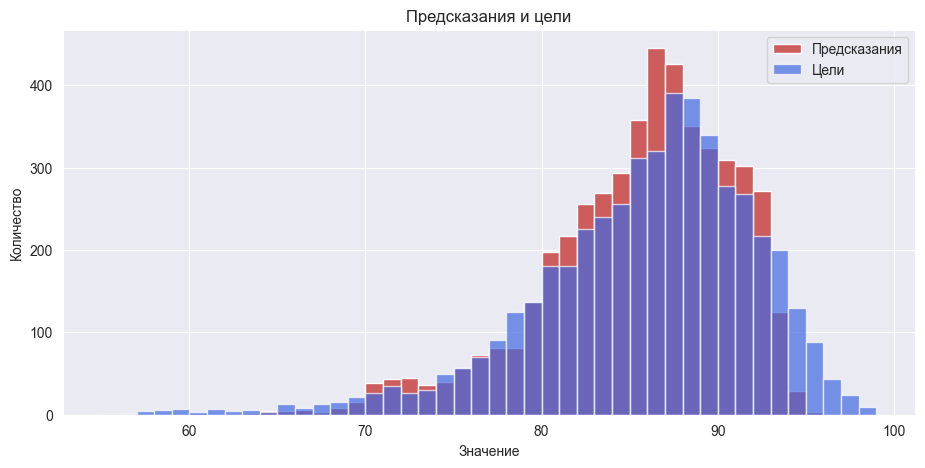

Rougher sMAPE: 3.224203038080319


In [47]:
# sMAPE для rougher
features_train, target_train, features_test, target_test = rougher()

model_LGBM = LGBMRegressor(random_state=RANDOM_STATE, 
                                   num_leaves=13, 
                                   min_child_samples=16, 
                                   max_depth=13, 
                                   n_estimators=100,
                                   learning_rate=0.090876, 
                                   verbose=-1)
model_LGBM.fit(features_train, target_train)
predicted_test = model_LGBM.predict(features_test)
sMAPE_rougher = sMAPE(target_test, predicted_test)

plot()

print('Rougher sMAPE:', sMAPE_rougher)

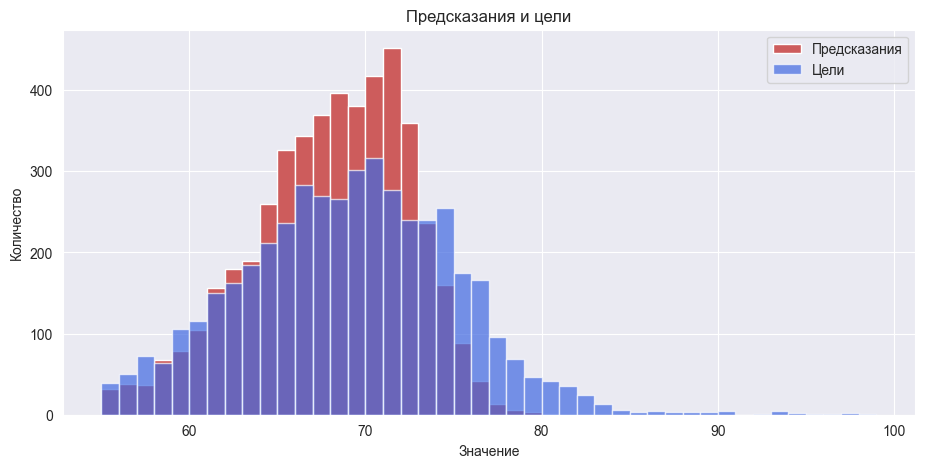

Final sMAPE: 6.276602310052458


In [48]:
# sMAPE для final
features_train, target_train, features_test, target_test = final()

model_lgbm_fin = LGBMRegressor(random_state=RANDOM_STATE, 
                                 num_leaves=6,
                                 max_depth=15, 
                                 n_estimators=100,
                                 min_child_samples=100,
                                 learning_rate=0.1, 
                                 verbose=-1)
model_lgbm_fin.fit(features_train, target_train)
predicted_test = model_lgbm_fin.predict(features_test)
sMAPE_final = sMAPE(target_test, predicted_test)

plot()

print('Final sMAPE:', sMAPE_final)

In [49]:
final_sMAPE = weighted_sMAPE(sMAPE_rougher, sMAPE_final)
print(f'Final weighted sMAPE: {final_sMAPE}')

Final weighted sMAPE: 5.513502492059423


Итоговое значение sMAPE нашей модели = 5.5, что лучше константы, полученной через `DummyRegressor`, так что модель можно назвать адекватной.

<a id='Выводы'></a>

<h2> Вывод

<h3>Цель проекта:

Подготовить прототип модели машинного обучения. Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды, тем самым помочь оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

<h3> Исходные данные

- `gold_industry_train.csv` — обучающая выборка;
- `gold_industry_test.csv` — тестовая выборка;
- `gold_industry_full.csv` — исходные данные.

Наименование признаков соответствует структуре:

`[этап].[тип_параметра].[название_параметра]`

Возможные значения для блока `[этап]`:

- *rougher* — флотация
- *primary_cleaner* — первичная очистка
- *secondary_cleaner* — вторичная очистка
- *final* — финальные характеристики

Возможные значения для блока `[тип_параметра]`:

- *input* — параметры сырья
- *output* — параметры продукта
- *state* — параметры, характеризующие текущее состояние этапа
- *calculation* — расчётные характеристики

<h3> Выводы

Перед работой с данными мы изучили содержание и распределение в каждом из датасетов, выявив следующее:

- Количество столбцов в трейне и исходном датасете совпадают
- Дубликаты отсутствуют
- Пропусков довольно много
- Заметны нули в финальных характеристиках и других признаках

---

При подготовке данных мы:

- Убедились в корректности рассчетов эффективности обогащения 
- Проанализировали признаки, недоступные в тестовой выборке
- Добавили в тестовую выборку целевые признаки
- Сменили тип данных `date`
- Удалили пропуски

---

В анализе данных мы узнали, что:

- Концентрация золота регулярно растет на каждом этапе, что хорошо для бизнеса
- Концентрация серебра идет на спад
- Показатели свинца в концентрате после первой очистки и в финальном концентрате довольно близки
- Довольно много выбросов в нулевых значениях в концентратах после первой очистки
- Распределения размеров гранул исходного сырья на обучающей и тестовой выборках почти не отличаются

---

В части проекта построения модели мы:
- Выделили признаки и целевые значения
- Применили масштабирование 
- Исследовали несколько моделей
- Выбрали модель с лучшим показателем sMAPE и проверили её на тестовой выборке

В качестве финальной модели мы выбрали `LGBMRegressor()` и получили значение итогового sMAPE = 5.5